# Can the filtered drag models capture the notion of power?

Before, we were comparing our models against the notion of total work. Now, we will compare them against a different physical truth. We still want to predict drag force from our input features, but now we want to check that our model is also capturing the notion of total power, which is given by:

$P = F \cdot u$

More specifically, we are interested in $P_{flux}$, which is given by:

$P_{flux} = \int P dx = \int F_{D}u dx$, where $D$ refers to drag. We estimate this by $\sum F_{D}(x_{i}) \cdot u(x_{i}) \cdot dx$

### Import and prepare data

In [2]:
import OpenMORe.OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.OpenMORe.utilities import *
import pandas as pd
from numpy import genfromtxt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

In [214]:
# pip install tensorflow-datasets

In [3]:
cu4_drag_force = genfromtxt('cu4_drag_force.csv', delimiter=',')

In [4]:
cu4_drag_force = pd.DataFrame(cu4_drag_force, columns=["x","eta","u","v","pressure","deta_dx","drag_force"])
cu4_drag_force['dx'] = cu4_drag_force['x'].diff()
cu4_drag_force.head(10)

,x,eta,u,v,pressure,deta_dx,drag_force,dx
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920,0.006763
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272,0.006768
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102,0.006763
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395,0.006768
5,-1.694840,1.508783,0.371505,0.989968,0.439815,-4.084629,-1.796480,0.006768
6,-1.688077,1.483601,0.377668,0.991503,0.379301,-3.723680,-1.412397,0.006763
7,-1.681309,1.437617,0.439839,1.028251,0.320993,-6.794235,-2.180900,0.006768
8,-1.674547,1.426394,0.445528,1.022112,0.250190,-1.659466,-0.415181,0.006763
9,-1.667779,1.385063,0.478104,1.059373,0.191636,-6.106723,-1.170268,0.006768


In [5]:
dx = 0.006763

cu4_pos_drag = cu4_drag_force.copy()
cu4_neg_drag = cu4_drag_force.copy()

# apply filters for drag force
cu4_pos_drag[cu4_pos_drag['deta_dx'] < 0] = 0
cu4_neg_drag[cu4_neg_drag['deta_dx'] > 0] = 0

### Run the models again to have them saved in this notebook

Helper functions.

In [6]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

Negative drag model.

In [8]:
# Prepare the data
cu4_neg_drag = cu4_neg_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_neg_drag = cu4_neg_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_neg_drag = cu4_neg_drag.drop(train_dataset_cu4_neg_drag.index)

train_dataset_cu4_neg_drag.pop('pressure')
test_dataset_cu4_neg_drag.pop('pressure')

train_dataset_cu4_neg_drag.pop('deta_dx')
test_dataset_cu4_neg_drag.pop('deta_dx')

train_dataset_cu4_neg_drag.pop('dx')
test_dataset_cu4_neg_drag.pop('dx')

print("shape of training dataset: ", train_dataset_cu4_neg_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_neg_drag.shape)

train_features_cu4_neg_drag = train_dataset_cu4_neg_drag.copy()
test_features_cu4_neg_drag = test_dataset_cu4_neg_drag.copy()

train_labels_cu4_neg_drag = train_features_cu4_neg_drag.pop('drag_force')
test_labels_cu4_neg_drag = test_features_cu4_neg_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_neg_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_neg_drag.adapt(np.array(train_features_cu4_neg_drag))

first = np.array(train_features_cu4_neg_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_neg_drag(first).numpy())

# Build the model
dnn_model_cu4_neg_drag = build_and_compile_model(normalizer_cu4_neg_drag)
dnn_model_cu4_neg_drag.summary()

shape of training dataset:  (8191, 5)
shape of testing dataset:  (2048, 5)


2022-11-26 08:33:15.200396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First example: [[0.9  1.54 1.13 1.02]]

Normalized: [[1.43 2.19 1.32 1.13]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [9]:
%%time
history_cu4_neg_drag = dnn_model_cu4_neg_drag.fit(
    train_features_cu4_neg_drag,
    train_labels_cu4_neg_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 35 s, sys: 6.09 s, total: 41.1 s
Wall time: 26 s


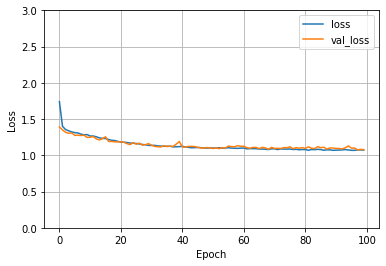

In [10]:
plot_loss(history_cu4_neg_drag)

Positive drag model.

In [105]:
# Prepare the data
cu4_pos_drag = cu4_pos_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_pos_drag = cu4_pos_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_pos_drag = cu4_pos_drag.drop(train_dataset_cu4_pos_drag.index)

train_dataset_cu4_pos_drag.pop('pressure')
test_dataset_cu4_pos_drag.pop('pressure')

train_dataset_cu4_pos_drag.pop('deta_dx')
test_dataset_cu4_pos_drag.pop('deta_dx')

train_dataset_cu4_pos_drag.pop('dx')
test_dataset_cu4_pos_drag.pop('dx')

print("shape of training dataset: ", train_dataset_cu4_pos_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_pos_drag.shape)
print("training dataset: ", train_dataset_cu4_pos_drag)

train_features_cu4_pos_drag = train_dataset_cu4_pos_drag.copy()
test_features_cu4_pos_drag = test_dataset_cu4_pos_drag.copy()

train_labels_cu4_pos_drag = train_features_cu4_pos_drag.pop('drag_force')
test_labels_cu4_pos_drag = test_features_cu4_pos_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_pos_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_pos_drag.adapt(np.array(train_features_cu4_pos_drag))


first = np.array(train_features_cu4_pos_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_pos_drag(first).numpy())

# Build the model
dnn_model_cu4_pos_drag = build_and_compile_model(normalizer_cu4_pos_drag)
dnn_model_cu4_pos_drag.summary()

shape of training dataset:  (8190, 5)
shape of testing dataset:  (2047, 5)
training dataset:               x       eta         u         v  drag_force
5509  0.000000  0.000000  0.000000  0.000000    0.000000
4128  0.000000  0.000000  0.000000  0.000000    0.000000
2414  0.747623  0.825223 -0.419315 -0.601937    6.399172
6506  0.720562  0.543915 -0.875699 -0.088316   18.902099
7049  0.000000  0.000000  0.000000  0.000000    0.000000
...        ...       ...       ...       ...         ...
7280 -0.970900  0.978734 -1.368781  0.074809   18.764796
3744  0.000000  0.000000  0.000000  0.000000    0.000000
5352 -0.158996  0.389009 -1.136506 -0.518907    9.294384
591  -1.194170 -1.018756 -1.161022 -1.984114   -0.072715
4799  0.000000  0.000000  0.000000  0.000000    0.000000

[8190 rows x 5 columns]
train features:               x       eta         u         v
5509  0.000000  0.000000  0.000000  0.000000
4128  0.000000  0.000000  0.000000  0.000000
2414  0.747623  0.825223 -0.419315 -0.601937


In [12]:
%%time
history_cu4_pos_drag = dnn_model_cu4_pos_drag.fit(
    train_features_cu4_pos_drag,
    train_labels_cu4_pos_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 36.5 s, sys: 6.37 s, total: 42.8 s
Wall time: 26.8 s


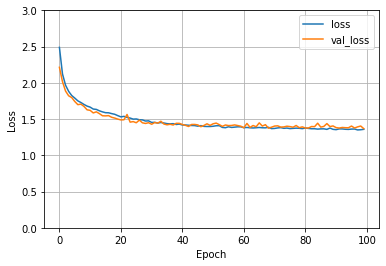

In [13]:
plot_loss(history_cu4_pos_drag)

### True power predictions against unfiltered drag force values

Recall that cu4_neg_drag was copied from cu4_drag_force. And the test_features_cu4_neg_drag were sampled from cu4_neg_drag. That means that we can use the indices of the test_features_cu4_neg_drag to map back to the original data (cu4_drag_force). That means that we can get the unfiltered drag force and u values for all of our testing datapoints! This is all that we need to calculate the total power values.

In [14]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_neg_drag.index)][['drag_force', 'u']]

In [15]:
# Uncomment the following to inspect them

test_features_cu4_neg_drag = test_features_cu4_neg_drag[['x','eta','u','v']]
#test_dataset_cu4_neg_drag
test_features_cu4_neg_drag
#test_labels_cu4_neg_drag

,x,eta,u,v
1,-1.721907,1.592266,0.258540,0.806480
14,-1.633949,1.105053,0.588292,1.079666
22,-1.579821,0.517113,0.885603,1.000114
26,-1.552759,0.274601,1.053696,0.935484
27,-1.545991,0.202614,1.132054,0.850646
...,...,...,...,...
10208,0.000000,0.000000,0.000000,0.000000
10212,0.000000,0.000000,0.000000,0.000000
10222,0.000000,0.000000,0.000000,0.000000
10224,0.000000,0.000000,0.000000,0.000000


In [16]:
predicted_neg_drag_force = dnn_model_cu4_neg_drag.predict(test_features_cu4_neg_drag)

64/64 [==============================] - 0s 1ms/step


Now, we will compare real power against predicted power. It makes sense that the power is negative since the waves are exerting negative force on the overhead wind.

In [17]:
products = dx * np.squeeze(true_drag_force)['drag_force'] * np.squeeze(true_drag_force)['u']
products
real_work = np.sum(products)
real_work

-3.308508135133584

In [18]:
products = dx * np.squeeze(predicted_neg_drag_force) * np.squeeze(true_drag_force)['u']
predicted_work = np.sum(products)
predicted_work

23.650970018661944

The negative DNN is not very good at predicting overall power. The percent error is ginormous, at 814.9%!

In [19]:
np.abs((predicted_work - real_work) / real_work) * 100

814.8530108633695

For reference, the mean absolute error is about 1.14 (relatively small!)

In [20]:
true_neg_drag_force = np.expand_dims(test_labels_cu4_neg_drag, axis=1)
np.sum(np.abs(true_neg_drag_force - predicted_neg_drag_force)) / len(predicted_neg_drag_force) 

1.1355150014071254

How does the positive model do? I predict not much better...

In [21]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_pos_drag.index)][['drag_force', 'u']]

In [22]:
# Uncomment the following to inspect them

test_features_cu4_pos_drag = test_features_cu4_pos_drag[['x','eta','u','v']]
#test_dataset_cu4_neg_drag
# test_features_cu4_pos_drag
#test_labels_cu4_neg_drag

In [23]:
predicted_pos_drag_force = dnn_model_cu4_pos_drag.predict(test_features_cu4_pos_drag)

64/64 [==============================] - 0s 2ms/step


In [24]:
products = dx * np.squeeze(true_drag_force)['drag_force'] * np.squeeze(true_drag_force)['u']
products 
real_power = np.sum(products)
real_power

-3.308508135133584

In [25]:
products = dx * np.squeeze(predicted_pos_drag_force) * np.squeeze(true_drag_force)['u']
predicted_power = np.sum(products)
predicted_power

-27.324726543655306

At least the sign is right here. But the percent error is still huge, at 814.9% (slightly more than the negative-trained DNN, which was 1169.9%).

In [26]:
np.abs((predicted_work - real_work) / real_work) * 100

814.8530108633695

For reference, the mean absolute error was 1.41 (relatively small).

In [27]:
true_pos_drag_force = np.expand_dims(test_labels_cu4_pos_drag, axis=1)
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force)) / len(predicted_pos_drag_force) 

1.408669463381053

### Training the positive-filtered DNN to capture the notion of power

In [504]:
# Prepare the data
cu4_power = cu4_pos_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_power = cu4_power.sample(frac=0.8, random_state=0)
test_dataset_cu4_power = cu4_power.drop(train_dataset_cu4_power.index)

train_dataset_cu4_power.pop('pressure')
test_dataset_cu4_power.pop('pressure')

train_dataset_cu4_power.pop('deta_dx')
test_dataset_cu4_power.pop('deta_dx')

train_dataset_cu4_power.pop('dx')
test_dataset_cu4_power.pop('dx')

print("shape of training dataset: ", train_dataset_cu4_power.shape)
print("shape of testing dataset: ", test_dataset_cu4_power.shape)
# print("training dataset: ", train_dataset_cu4_power)

train_features_cu4_power = train_dataset_cu4_power.copy()
test_features_cu4_power = test_dataset_cu4_power.copy()

train_labels_cu4_power = train_features_cu4_power[['drag_force','u']]
test_labels_cu4_power = test_features_cu4_power[['drag_force','u']]
# print("train labels: ", train_labels_cu4_power)

train_features_cu4_power.pop('drag_force')
test_features_cu4_power.pop('drag_force')

# print("train features: ", train_features_cu4_power)
normalizer_cu4_power = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_power.adapt(np.array(train_features_cu4_power))

# train_labels_cu4_power

shape of training dataset:  (8189, 5)
shape of testing dataset:  (2047, 5)


In [505]:
# input is tensors
def calculate_power(drag_force, u):
    prod1 = tf.math.multiply(drag_force, u)
    product = tf.math.scalar_mul(dx, prod1)
    my_sum = tf.math.reduce_sum(product)
    return my_sum

# inputs are both tensors (keras built on top of tensorflow)
def my_loss_fn(y_true, y_pred):
    # drag_force is at index 0, u is at index 1
    drag_force_true = tf.gather(y_true, [0], axis=1)
    u_true = tf.gather(y_true, [1], axis=1)
    
    drag_force_pred = tf.gather(y_pred, [0], axis=1)
    u_pred = tf.gather(y_pred, [1], axis=1)
    
    power_true = calculate_power(drag_force_true, u_true)
    power_pred = calculate_power(drag_force_pred, u_pred)
    
    # Note that we are using mean absolute error as opposed to square error. Important to specify for your paper!
    first_loss = tf.math.scalar_mul(0, tf.math.scalar_mul(1 / tf.size(y_true), tf.cast(tf.abs(y_true - y_pred), tf.float64)))
    second_loss = tf.math.scalar_mul(1, tf.cast(tf.abs(power_true - power_pred), tf.float64))
    
    squared_difference = first_loss + second_loss
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

def build_and_compile_model_power(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Build the model
dnn_model_cu4_power = build_and_compile_model_power(normalizer_cu4_power)
dnn_model_cu4_power.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_28 (Normaliza  (None, 4)                9         
 tion)                                                           
                                                                 
 dense_150 (Dense)           (None, 64)                320       
                                                                 
 dense_151 (Dense)           (None, 64)                4160      
                                                                 
 dense_152 (Dense)           (None, 2)                 130       
                                                                 
Total params: 4,619
Trainable params: 4,610
Non-trainable params: 9
_________________________________________________________________


In [109]:
%%time
history_cu4_power = dnn_model_cu4_power.fit(
    train_features_cu4_power,
    train_labels_cu4_power,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 42.9 s, sys: 7.69 s, total: 50.6 s
Wall time: 30.5 s


In [92]:
def plot_loss_power(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.3])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

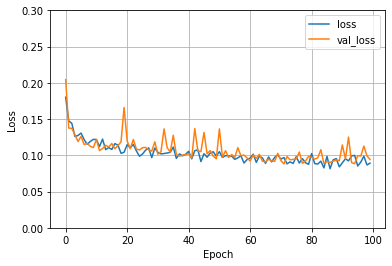

In [110]:
plot_loss_power(history_cu4_power)

### How well did it work?

Recall that cu4_neg_drag was copied from cu4_drag_force. And the test_features_cu4_neg_drag were sampled from cu4_neg_drag. That means that we can use the indices of the test_features_cu4_neg_drag to map back to the original data (cu4_drag_force). That means that we can get the unfiltered drag force and u values for all of our testing datapoints! This is all that we need to calculate the total power values.

In [113]:
true_power = cu4_power[cu4_power.index.isin(test_features_cu4_power.index)][['drag_force', 'u']]
true_power

,drag_force,u
4,0.000000,0.000000
17,0.000000,0.000000
25,0.000000,0.000000
29,0.000000,0.000000
30,0.000000,0.000000
...,...,...
10204,12.206702,-1.199148
10208,7.784577,-1.022913
10211,14.954201,-1.042609
10212,16.422499,-0.976752


In [114]:
test_features_cu4_power = test_features_cu4_power[['x','eta','u','v']]
# test_features_cu4_power

In [180]:
predicted_power = dnn_model_cu4_power.predict(test_features_cu4_power)

64/64 [==============================] - 0s 1ms/step


Now, we will compare real power against predicted power. It makes sense that the power is negative since the waves are exerting negative force on the overhead wind.

In [181]:
products = dx * np.squeeze(true_power)['drag_force'] * np.squeeze(true_power)['u']
products
real_power = np.sum(products)
real_power

-28.33418935082215

In [182]:
products = tf.math.multiply(tf.gather(predicted_power, [0], axis=1), tf.gather(predicted_power, [1], axis=1))
products2 = tf.math.scalar_mul(dx, products)
pred_power = np.sum(products2)
pred_power

-29.630783

Now, it is fantastic at predicting power (not a surprise)! The percent error is about 4.6%.

In [183]:
np.abs((pred_power - real_power) / real_power) * 100

4.576074911403509

What about if drag force is the only takeaway from the model? Should be the same, actually, since u should be a 1:1 mapping. But it's not the same. Interesting.

In [184]:
u = tf.convert_to_tensor(true_power['u'].to_numpy())
u = tf.expand_dims(u,axis=1)
products = tf.math.multiply(tf.cast(tf.gather(predicted_power, [0], axis=1), tf.float64), tf.cast(u, tf.float64))
products2 = tf.math.scalar_mul(dx, products)
pred_power = np.sum(products2)
pred_power

-14.110442325743167

The percent error on this is much bigger, at about 50.2%. This is a pretty suspicious number, 50%, when you consider that there's two output variables. My idea is that u is being shrunk to about half the value that it should be, and drag_force is twice as big as it should be, or something along those lines. Correction: after inspecting the drag force and u predictions, we can see that the model isn't predicting either of them very well, but is predicting their product pretty decently.

In [185]:
np.abs((pred_power - real_power) / real_power) * 100

50.19994342864891

So it seems that u is not being straightforwardly copied over like a 1:1 mapping from the input to the output. I guess that makes sense, since the model is trying to optimize for a product, and we have not punished changes in u (IDEA: I SHOULD EMBED THAT INTO THE LOSS FUNCTION SO THAT WE ARE OPTIMIZING FOR THE PRODUCT BUT DRAG FORCE IS THE ONLY THING THAT'S REALLY CHANGING).

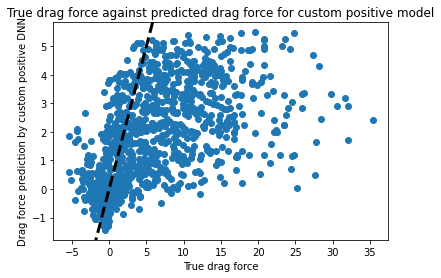

In [194]:
predicted_drag_force = np.squeeze(np.array(tf.gather(predicted_power, [0], axis=1)))
plt.scatter(true_power['drag_force'], predicted_drag_force)
plt.title("True drag force against predicted drag force for custom power model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by custom power DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

The black dashed line is y=x. We can see that the predicted drag force has a skew to be shrunken a lot compared to its true value. Another notable difference is that the zeroed-out drag forces are hardly being predicted. That's probably because they would lead to zero products and then the model would be training for the power integral with fewer datapoints (it's like it would be omitting datapoints from consideration). In any case, what's going on with the u values?

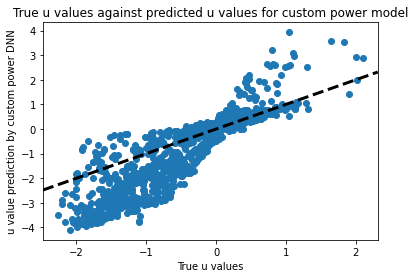

In [195]:
predicted_u = np.squeeze(np.array(tf.gather(predicted_power, [1], axis=1)))
plt.scatter(true_power['u'], predicted_u)
plt.title("True u values against predicted u values for custom power model")
plt.xlabel("True u values")
plt.ylabel("u value prediction by custom power DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

When the true value of u is zero, the model is likely to predict 0 (or near zero). As the value of u skews further and further from 0, the model is more likely to overcompensate. Negative u values are still getting negative predictions, just the predictions are a bit exaggerated.

What about if you view them together, like in a 3D graph? This could give us interesting insights. But not sure what the axes would be in this case, because you have 4 series of interest: true u, predicted u, true drag force, predicted drag force (power and work predictions are just scalars).

Is it still decent at predicting drag force in general? What about work?

For reference, the mean absolute error for drag_force is about 2.52. This is about twice as big when compared to the mean absolute error for the positive drag force with total work constraint (value was 1.14, which was relatively small!).

In [210]:
np.sum(np.abs(true_power['drag_force'] - my_predictions[:, 0])) / len(true_power) 

2.523286898251457

So it is not super decent at predicting drag force in general anymore. What about work? Nope, it is horrific at predicting work. The percent error is 70%. This makes sense, because the model simply isn't optimizing for work.

In [211]:
products = dx * true_power['drag_force']
real_work = np.sum(products)
real_work

41.49613748988095

In [212]:
products = dx * np.squeeze(np.array(tf.gather(predicted_power, [0], axis=1)))
predicted_work = np.sum(products)
predicted_work

12.39043

In [213]:
np.abs((predicted_work - real_work) / real_work) * 100

70.14076200836541

Right now, the model is really good at predicting power. It's got the glorious 4% error in that realm. But it's still not great at predicting drag force or work (even though those matter less). If we play around with the loss function, can we improve the model in that capacity without affecting the power prediction metrics? Specifically, if we penalize high prediction differences for drag_force, can the model perform nearly as well? 

### Improve power model for drag force predictions

In [735]:
# Prepare the data
cu4_power_drag = cu4_pos_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_power_drag = cu4_power_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_power_drag = cu4_power_drag.drop(train_dataset_cu4_power_drag.index)

train_dataset_cu4_power_drag.pop('pressure')
test_dataset_cu4_power_drag.pop('pressure')

train_dataset_cu4_power_drag.pop('deta_dx')
test_dataset_cu4_power_drag.pop('deta_dx')

train_dataset_cu4_power_drag.pop('dx')
test_dataset_cu4_power_drag.pop('dx')

# print("shape of training dataset: ", train_dataset_cu4_power_drag.shape)
# print("shape of testing dataset: ", test_dataset_cu4_power_drag.shape)
# print("training dataset: ", train_dataset_cu4_power)

train_features_cu4_power_drag = train_dataset_cu4_power_drag.copy()
test_features_cu4_power_drag = test_dataset_cu4_power_drag.copy()

train_labels_cu4_power_drag = train_features_cu4_power_drag[['drag_force','u']]
test_labels_cu4_power_drag = test_features_cu4_power_drag[['drag_force','u']]
# print("train labels: ", train_labels_cu4_power)

train_features_cu4_power_drag.pop('drag_force')
test_features_cu4_power_drag.pop('drag_force')

# print("train features: ", train_features_cu4_power)
normalizer_cu4_power_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_power_drag.adapt(np.array(train_features_cu4_power_drag))

# train_labels_cu4_power

In [736]:
# input is tensors
def calculate_power(drag_force, u):
    prod1 = tf.math.multiply(drag_force, u)
    product = tf.math.scalar_mul(dx, prod1)
    my_sum = tf.math.reduce_sum(product)
    return my_sum

# inputs are both tensors (keras built on top of tensorflow)
def my_loss_fn(y_true, y_pred):
    # drag_force is at index 0, u is at index 1
    drag_force_true = tf.gather(y_true, [0], axis=1)
    u_true = tf.gather(y_true, [1], axis=1)
#     tf.print("size of y_true: ", tf.shape(y_true))
    
    drag_force_pred = tf.gather(y_pred, [0], axis=1)
    u_pred = tf.gather(y_pred, [1], axis=1)
    
    power_true = calculate_power(drag_force_true, u_true)
    power_pred = calculate_power(drag_force_pred, u_pred)
    
    # Note that we are sometimes using mean absolute error as opposed to square error. Important to specify for your paper! (tf.abs instead of tf.math.square)
    first_loss = tf.math.scalar_mul(1, tf.math.scalar_mul(1 / tf.size(y_true), tf.cast(tf.math.square(drag_force_true - drag_force_pred), tf.float64)))
    second_loss = tf.math.scalar_mul(0, tf.cast(tf.math.square(power_true - power_pred), tf.float64))
    third_loss = tf.math.scalar_mul(0.5, tf.math.scalar_mul(1 / tf.size(y_true), tf.cast(tf.math.square(u_true - u_pred), tf.float64)))
    
    squared_difference = first_loss + second_loss + third_loss
#     tf.print("my loss: ", tf.reduce_mean(squared_difference, axis=-1))
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

def build_and_compile_model_power(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Build the model
dnn_model_cu4_power_drag = build_and_compile_model_power(normalizer_cu4_power_drag)
dnn_model_cu4_power_drag.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_41 (Normaliza  (None, 4)                9         
 tion)                                                           
                                                                 
 dense_186 (Dense)           (None, 64)                320       
                                                                 
 dense_187 (Dense)           (None, 64)                4160      
                                                                 
 dense_188 (Dense)           (None, 2)                 130       
                                                                 
Total params: 4,619
Trainable params: 4,610
Non-trainable params: 9
_________________________________________________________________


In [737]:
%%time
history_cu4_power_drag = dnn_model_cu4_power_drag.fit(
    train_features_cu4_power_drag,
    train_labels_cu4_power_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 43.9 s, sys: 8.08 s, total: 52 s
Wall time: 31.5 s


In [738]:
def plot_loss_power(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

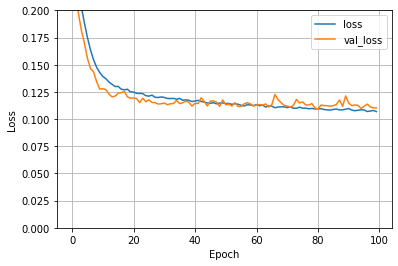

In [739]:
plot_loss_power(history_cu4_power_drag)

### How well did it work? Part two...

Recall that cu4_neg_drag was copied from cu4_drag_force. And the test_features_cu4_neg_drag were sampled from cu4_neg_drag. That means that we can use the indices of the test_features_cu4_neg_drag to map back to the original data (cu4_drag_force). That means that we can get the unfiltered drag force and u values for all of our testing datapoints! This is all that we need to calculate the total power values.

In [740]:
true_power = cu4_power[cu4_power.index.isin(test_features_cu4_power_drag.index)][['drag_force', 'u']]
true_power

,drag_force,u
4,0.000000,0.000000
17,0.000000,0.000000
25,0.000000,0.000000
29,0.000000,0.000000
30,0.000000,0.000000
...,...,...
10204,12.206702,-1.199148
10208,7.784577,-1.022913
10211,14.954201,-1.042609
10212,16.422499,-0.976752


In [741]:
test_features_cu4_power_drag = test_features_cu4_power_drag[['x','eta','u','v']]
# test_features_cu4_power_drag

In [742]:
predicted_power_drag = dnn_model_cu4_power_drag.predict(test_features_cu4_power_drag)

64/64 [==============================] - 0s 1ms/step


Now, we will compare real power against predicted power. It makes sense that the power is negative since the waves are exerting negative force on the overhead wind.

In [743]:
products = dx * np.squeeze(true_power)['drag_force'] * np.squeeze(true_power)['u']
products
real_power = np.sum(products)
real_power

-28.33418935082215

In [744]:
products = tf.math.multiply(tf.gather(predicted_power_drag, [0], axis=1), tf.gather(predicted_power_drag, [1], axis=1))
products2 = tf.math.scalar_mul(dx, products)
pred_power = np.sum(products2)
pred_power

-28.764729

The model does a bit worse at predicting power now. The hope is that the drag force predictions drastically improved, though. To be specific, the percent difference for power predictions increased from about 4.6% to about 17.5% after the edit to the custom loss function was implemented.

In [745]:
np.abs((pred_power - real_power) / real_power) * 100

1.519504193289847

Now, what's the result if drag force is the only takeaway from the model? The power prediction is even stronger, with percent error of about 11.0%. This is an interesting finding, since the model was supposed to be optimizing for power. 

In [746]:
u = tf.convert_to_tensor(true_power['u'].to_numpy())
u = tf.expand_dims(u,axis=1)
products = tf.math.multiply(tf.cast(tf.gather(predicted_power_drag, [0], axis=1), tf.float64), tf.cast(u, tf.float64))
products2 = tf.math.scalar_mul(dx, products)
pred_power = np.sum(products2)
pred_power

-28.737437383319328

In [747]:
np.abs((pred_power - real_power) / real_power) * 100

1.4231853521705826

Is the model predicting either drag force or u values well? (It would have no reason right now to really be predicting u values too well).

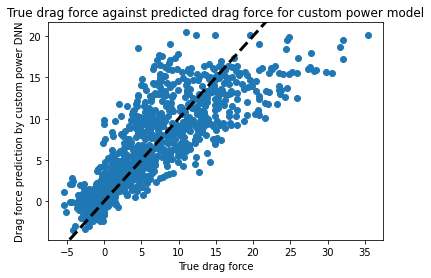

In [748]:
predicted_drag_force = np.squeeze(np.array(tf.gather(predicted_power_drag, [0], axis=1)))
plt.scatter(true_power['drag_force'], predicted_drag_force)
plt.title("True drag force against predicted drag force for custom power model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by custom power DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

The black dashed line is y=x. We can see that the predicted drag force lies along where it should, with some underpredictions. The u values are pretty good as well. We could calculate correlation with the dashed line, if we wanted to.

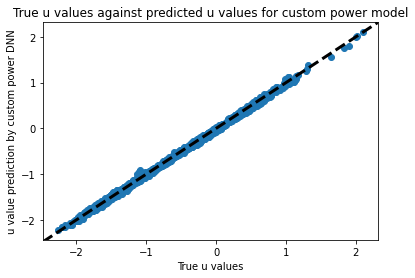

In [749]:
predicted_u = np.squeeze(np.array(tf.gather(predicted_power_drag, [1], axis=1)))
plt.scatter(true_power['u'], predicted_u)
plt.title("True u values against predicted u values for custom power model")
plt.xlabel("True u values")
plt.ylabel("u value prediction by custom power DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

Is it still decent at predicting drag force in general? What about work?

For reference, the mean absolute error for drag_force is about 1.86. This is pretty similar to the error associated with the positive drag force that had the total work constraint (value was 1.14, which was relatively small!).

In [750]:
predicted_drag_force = np.squeeze(np.array(tf.gather(predicted_power_drag, [0], axis=1)))
predicted_drag_force

array([ 0.02990136,  0.02990136,  0.02990136, ..., 12.43272   ,
       12.880987  , 15.001321  ], dtype=float32)

In [751]:
np.sum(np.abs(true_power['drag_force'] - predicted_drag_force)) / len(true_power) 

1.4001678054043285

##### Model with 3 terms in loss function (one to address u prediction error)

For reference, the mean absolute error for drag_force is about 1.86. This is pretty similar to the error associated with the positive drag force that had the total work constraint (value was 1.14, which was relatively small!).

In [754]:
predicted_u = np.squeeze(np.array(tf.gather(predicted_power_drag, [1], axis=1)))
predicted_u

array([-0.00368798, -0.00368798, -0.00368798, ..., -1.0801022 ,
       -1.0098469 , -0.90300393], dtype=float32)

In [755]:
np.sum(np.abs(true_power['u'] - predicted_u)) / len(true_power) 

0.0161794345940831

##### Continue

So, it's decent at predicting drag force now, with not that much takeaway from its ability to predict power. What about work? With the last model, the percent error was 70% (not good). Now, it is 29.7% (much better).

In [756]:
products = dx * true_power['drag_force']
real_work = np.sum(products)
real_work

41.49613748988095

In [757]:
products = dx * np.squeeze(np.array(tf.gather(predicted_power_drag, [0], axis=1)))
predicted_work = np.sum(products)
predicted_work

42.654778

In [758]:
np.abs((predicted_work - real_work) / real_work) * 100

2.7921635772897133

### Hypertuning loss function for double prediction model (drag force and u)

It seems that we can hypertune the parameters to have a model that predicts both power and work well. Here, we will play around with hyperparameters.

Let $d$ denote drag force and $u$ denote $u$. Here are the loss equations used for each model. The first 7 models are analogous to the mean_absolute_error loss function, whereas the last 7 models are based off of the mean_squared_error loss function.

Model 1: $|p_{true} - p_{pred}|$

Model 2: $0.1\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}| + 0.9|p_{true} - p_{pred}|$

Model 3: $0.3\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}| + 0.7|p_{true} - p_{pred}|$

Model 4: $0.5\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}| + 0.5|p_{true} - p_{pred}|$

Model 5: $0.7\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}| + 0.3|p_{true} - p_{pred}|$

Model 6: $0.9\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}| + 0.1|p_{true} - p_{pred}|$

Model 7: $\frac{1}{n}\sum_{i=1}^{n}|d_{i,true} - d_{i,pred}|$

-----------------------

Model 8: $(p_{true} - p_{pred})^{2}$

Model 9: $0.1\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.9(p_{true} - p_{pred})^{2}$

Model 10: $0.3\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.7(p_{true} - p_{pred})^{2}$

Model 11: $0.5\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.5(p_{true} - p_{pred})^{2}$

Model 12: $0.7\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.3(p_{true} - p_{pred})^{2}$

Model 13: $0.9\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.1(p_{true} - p_{pred})^{2}$

Model 14: $\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2}$


In [655]:
table = [['Loss equation number', 'Power % err (drag, u)', 'Power % err (drag)', 'Drag force MAE', 'Work %err'],
         ['1', '1.8','48.2','2.9','76.0'],
         ['2', '4.5','54.3','2.5','69.9'],
         ['3', '7.8','136.9','3.8','117.0'],
         ['4', '11.3','27.1','1.9','39.9'],
         ['5', '2.2','15.1','1.7','26.1'],
         ['6', '7.3','0.5','1.5','4.8'],
         ['7', '21.7','1.6','1.5','4.6'],
         ['8', '0.97','147.4','4.0','123.4'],
         ['9', '10.3','5.1','1.6','1.4'],
         ['10', '7.7','4.0','1.5','5.8'],
         ['11', '0.4','7.2','1.5','9.3'],
         ['12', '18.4','6.5','1.5','3.5'],
         ['13', '11.0','0.9','1.4','3.4'],
         ['14', '208.3','1.0','1.5','8.9']
        ]


print(tabulate(table, headers="firstrow", tablefmt="pipe"))

|   Loss equation number |   Power % err (drag, u) |   Power % err (drag) |   Drag force MAE |   Work %err |
|-----------------------:|------------------------:|---------------------:|-----------------:|------------:|
|                      1 |                    1.8  |                 48.2 |              2.9 |        76   |
|                      2 |                    4.5  |                 54.3 |              2.5 |        69.9 |
|                      3 |                    7.8  |                136.9 |              3.8 |       117   |
|                      4 |                   11.3  |                 27.1 |              1.9 |        39.9 |
|                      5 |                    2.2  |                 15.1 |              1.7 |        26.1 |
|                      6 |                    7.3  |                  0.5 |              1.5 |         4.8 |
|                      7 |                   21.7  |                  1.6 |              1.5 |         4.6 |
|                  

We can clearly see that some models perform better than others. Model 11 (mean squared error with 0.5 weights) is a notable model because the power prediction rocks (0.4% error) and the work prediction is also very fair (<10%). Model 6 is also notable (7.3% error for power, 4.6% error for work). You can clearly see that the inclusion of both terms is critical, as models 1, 7, 8, and 14 all have very high loss values (>20% and usually on the scale of 100%) for either power or work.

Let's investigate the trends of the performance metrics across the models, as the percentage of the loss dedicated mitigating drag force error increases.

First, we will take a look at the models which use mean absolute errors in their loss functions.

In [759]:
my_df = pd.DataFrame([['power % err',0,1.8,'red'],
                      ['power % err',0.1,4.5,'red'],
                      ['power % err',0.3,7.8,'red'],
                      ['power % err',0.5,11.3,'red'],
                      ['power % err',0.7,2.2,'red'],
                      ['power % err',0.9,7.3,'red'],
                      ['power % err',1,21.7,'red'],
                      ['power % err (drag)',0,48.2,'blue'],
                      ['power % err (drag)',0.1,54.3,'blue'],
                      ['power % err (drag)',0.3,136.9,'blue'],
                      ['power % err (drag)',0.5,27.1,'blue'],
                      ['power % err (drag)',0.7,15.1,'blue'],
                      ['power % err (drag)',0.9,0.5,'blue'],
                      ['power % err (drag)',1,1.6,'blue'],
                      ['work % err',0,76.0,'green'],
                      ['work % err',0.1,69.9,'green'],
                      ['work % err',0.3,117.0,'green'],
                      ['work % err',0.5,39.9,'green'],
                      ['work % err',0.7,26.1,'green'],
                      ['work % err',0.9,4.8,'green'],
                      ['work % err',1,4.6,'green']],
                     columns=['performance metric', 'proportion of loss function dedicated to drag force error', 'y','color'])

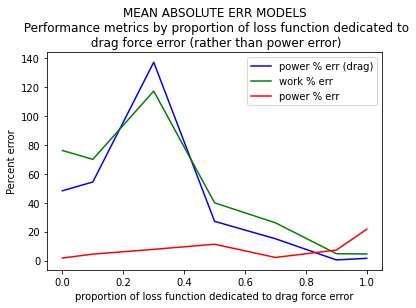

In [760]:
fig, ax = plt.subplots()

for key, grp in my_df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='proportion of loss function dedicated to drag force error', y='y', c=key, label=grp['performance metric'].iloc[0])

plt.legend(loc='best')
plt.title("MEAN ABSOLUTE ERR MODELS\n Performance metrics by proportion of loss function dedicated to\n drag force error (rather than power error)")
ax.set_ylabel("Percent error")
plt.show()

In [761]:
my_df = pd.DataFrame([['power % err',0,0.97,'red'],
                      ['power % err',0.1,10.3,'red'],
                      ['power % err',0.3,7.7,'red'],
                      ['power % err',0.5,0.4,'red'],
                      ['power % err',0.7,18.4,'red'],
                      ['power % err',0.9,11.0,'red'],
                      ['power % err',1,208.3,'red'],
                      ['power % err (drag)',0,147.4,'blue'],
                      ['power % err (drag)',0.1,5.1,'blue'],
                      ['power % err (drag)',0.3,4.0,'blue'],
                      ['power % err (drag)',0.5,7.2,'blue'],
                      ['power % err (drag)',0.7,6.5,'blue'],
                      ['power % err (drag)',0.9,0.9,'blue'],
                      ['power % err (drag)',1,1.0,'blue'],
                      ['work % err',0,123.4,'green'],
                      ['work % err',0.1,1.4,'green'],
                      ['work % err',0.3,5.8,'green'],
                      ['work % err',0.5,9.3,'green'],
                      ['work % err',0.7,3.5,'green'],
                      ['work % err',0.9,3.4,'green'],
                      ['work % err',1,8.9,'green']],
                     columns=['performance metric', 'proportion of loss function dedicated to drag force error', 'y','color'])

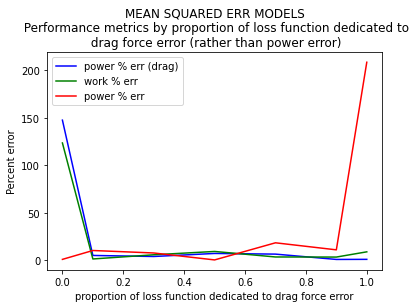

In [762]:
fig, ax = plt.subplots()

for key, grp in my_df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='proportion of loss function dedicated to drag force error', y='y', c=key, label=grp['performance metric'].iloc[0])

plt.legend(loc='best')
plt.title("MEAN SQUARED ERR MODELS\n Performance metrics by proportion of loss function dedicated to\n drag force error (rather than power error)")
ax.set_ylabel("Percent error")
plt.show()

In [763]:
my_df = pd.DataFrame([['power % err',0.1,10.3,'red'],
                      ['power % err',0.3,7.7,'red'],
                      ['power % err',0.5,0.4,'red'],
                      ['power % err',0.7,18.4,'red'],
                      ['power % err',0.9,11.0,'red'],
                      ['power % err (drag)',0.1,5.1,'blue'],
                      ['power % err (drag)',0.3,4.0,'blue'],
                      ['power % err (drag)',0.5,7.2,'blue'],
                      ['power % err (drag)',0.7,6.5,'blue'],
                      ['power % err (drag)',0.9,0.9,'blue'],
                      ['work % err',0.1,1.4,'green'],
                      ['work % err',0.3,5.8,'green'],
                      ['work % err',0.5,9.3,'green'],
                      ['work % err',0.7,3.5,'green'],
                      ['work % err',0.9,3.4,'green']],
                     columns=['performance metric', 'proportion of loss function dedicated to drag force error', 'y','color'])

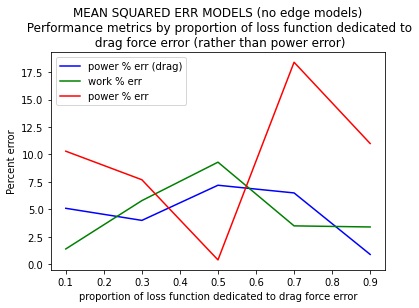

In [764]:
fig, ax = plt.subplots()

for key, grp in my_df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='proportion of loss function dedicated to drag force error', y='y', c=key, label=grp['performance metric'].iloc[0])

plt.legend(loc='best')
plt.title("MEAN SQUARED ERR MODELS (no edge models)\n Performance metrics by proportion of loss function dedicated to\n drag force error (rather than power error)")
ax.set_ylabel("Percent error")
plt.show()

In [765]:
my_df = pd.DataFrame([['MAE, power % err',0,1.8,'#e61000'],
                      ['MAE, power % err',0.1,4.5,'#e61000'],
                      ['MAE, power % err',0.3,7.8,'#e61000'],
                      ['MAE, power % err',0.5,11.3,'#e61000'],
                      ['MAE, power % err',0.7,2.2,'#e61000'],
                      ['MAE, power % err',0.9,7.3,'#e61000'],
                      ['MAE, power % err',1,21.7,'#e61000'],
                      ['MAE, power % err (drag)',0,48.2,'#b21000'],
                      ['MAE, power % err (drag)',0.1,54.3,'#b21000'],
                      ['MAE, power % err (drag)',0.3,136.9,'#b21000'],
                      ['MAE, power % err (drag)',0.5,27.1,'#b21000'],
                      ['MAE, power % err (drag)',0.7,15.1,'#b21000'],
                      ['MAE, power % err (drag)',0.9,0.5,'#b21000'],
                      ['MAE, power % err (drag)',1,1.6,'#b21000'],
                      ['MAE, work % err',0,76.0,'#7e1000'],
                      ['MAE, work % err',0.1,69.9,'#7e1000'],
                      ['MAE, work % err',0.3,117.0,'#7e1000'],
                      ['MAE, work % err',0.5,39.9,'#7e1000'],
                      ['MAE, work % err',0.7,26.1,'#7e1000'],
                      ['MAE, work % err',0.9,4.8,'#7e1000'],
                      ['MAE, work % err',1,4.6,'#7e1000'],
                      ['MSE, power % err',0.1,10.3,'#3a3eff'],
                      ['MSE, power % err',0.3,7.7,'#3a3eff'],
                      ['MSE, power % err',0.5,0.4,'#3a3eff'],
                      ['MSE, power % err',0.7,18.4,'#3a3eff'],
                      ['MSE, power % err',0.9,11.0,'#3a3eff'],
                      ['MSE, power % err (drag)',0.1,5.1,'#3a3ecf'],
                      ['MSE, power % err (drag)',0.3,4.0,'#3a3ecf'],
                      ['MSE, power % err (drag)',0.5,7.2,'#3a3ecf'],
                      ['MSE, power % err (drag)',0.7,6.5,'#3a3ecf'],
                      ['MSE, power % err (drag)',0.9,0.9,'#3a3ecf'],
                      ['MSE, work % err',0.1,1.4,'#3a3e7b'],
                      ['MSE, work % err',0.3,5.8,'#3a3e7b'],
                      ['MSE, work % err',0.5,9.3,'#3a3e7b'],
                      ['MSE, work % err',0.7,3.5,'#3a3e7b'],
                      ['MSE, work % err',0.9,3.4,'#3a3e7b']],
                     columns=['performance metric', 'proportion of loss function dedicated to drag force error', 'y','color'])

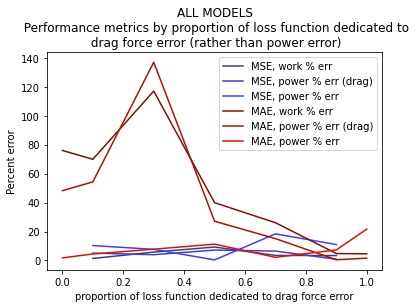

In [766]:
fig, ax = plt.subplots()

for key, grp in my_df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='proportion of loss function dedicated to drag force error', y='y', c=key, label=grp['performance metric'].iloc[0])

plt.legend(loc='best')
plt.title("ALL MODELS\n Performance metrics by proportion of loss function dedicated to\n drag force error (rather than power error)")
ax.set_ylabel("Percent error")
plt.show()

You can see that the best model is either MSE at 0.5 or MAE at 0.9.

### Optimizing for power only with drag force predictions, not with u values

This isn't exactly what we talked about in our last meeting (1:1 correspondence for u values). But we can take a look at that as well.

If we penalize loss for u, we can keep u values almost the same and simply predict drag force values while trying to capture power (or both power and work). We are going to build off of our best model from before (MSE at 0.5) but now we are editing the loss function even more. Here is the new loss function:

$0.5\frac{1}{n}\sum_{i=1}^{n}(d_{i,true} - d_{i,pred})^{2} + 0.5(p_{true} - p_{pred})^{2} + 0.5\frac{1}{n}\sum_{i=1}^{n}(u_{i,true} - u_{i,pred})^{2}$

Note that we are weighing the u squared differences just as much as each other term.

After training the model, we want to make sure that our u values are minimally altered by the model. MAE will be our metric to assess this.

The results were great!

power with u and drag force % err: 1.5

power with just drag force % err: 1.4

drag force MAE: 1.4

work % err: 2.8

u MAE: 0.02 (this is exactly what we wanted)

Let's compare these results to our two best models so far (MSE at 0.5, MAE at 0.9)

In [10]:
df = pd.DataFrame([['power % err',7.3,0.4,1.5],
                   ['power % err (drag)',0.5,7.2,1.4],
                   ['work % err',4.8,9.3,2.8]],
                  columns=["Performance metric", "0.9 MAE", "0.5 MSE", "u (MSE)"])

df

,Performance metric,0.9 MAE,0.5 MSE,u (MSE)
0,power % err,7.3,0.4,1.5
1,power % err (drag),0.5,7.2,1.4
2,work % err,4.8,9.3,2.8


In [9]:
np.savetxt("graphic3.csv", df, delimiter=",")

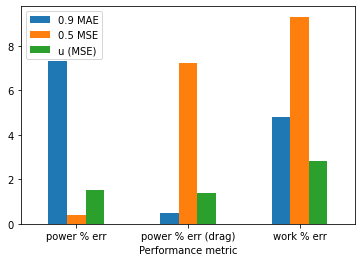

In [6]:
ax = df.plot(x="Performance metric", y=["0.9 MAE", "0.5 MSE", "u (MSE)"], kind="bar", rot=0)

We can see that when u is controlled, the model is better at optimizing across the three metrics. Idea: turning one knob instead of 2. With a limited number of epochs, when turning 1 knob, maybe you can reach better optimums.

### Predicting the product of drag force and u for power DNN (instead of each separately)

A downside to this technique is that you cannot optimize for both power and work (when predicting each separately, you can). You also can't tell if the model is predicting either drag_force or u well. But we will see if it can improve our ability to capture the notion of power anyhow.

In [818]:
# Prepare the data
cu4_power_product = cu4_pos_drag.copy()[1:]
cu4_power_product['product'] = cu4_power_product['u'] * cu4_power_product['drag_force']

# Split the data into train and test
train_dataset_cu4_power_product = cu4_power_product.sample(frac=0.8, random_state=0)
test_dataset_cu4_power_product = cu4_power_product.drop(train_dataset_cu4_power_drag.index)

train_dataset_cu4_power_product.pop('pressure')
test_dataset_cu4_power_product.pop('pressure')

train_dataset_cu4_power_product.pop('deta_dx')
test_dataset_cu4_power_product.pop('deta_dx')

train_dataset_cu4_power_product.pop('dx')
test_dataset_cu4_power_product.pop('dx')

# print("shape of training dataset: ", train_dataset_cu4_power_drag.shape)
# print("shape of testing dataset: ", test_dataset_cu4_power_drag.shape)
# print("training dataset: ", train_dataset_cu4_power)

train_features_cu4_power_product = train_dataset_cu4_power_product.copy()
test_features_cu4_power_product = test_dataset_cu4_power_product.copy()

train_labels_cu4_power_product = train_features_cu4_power_product['product']
test_labels_cu4_power_product = test_features_cu4_power_product['product']
# print("train labels: ", train_labels_cu4_power_product)

train_features_cu4_power_product.pop('drag_force')
test_features_cu4_power_product.pop('drag_force')

train_features_cu4_power_product.pop('product')
test_features_cu4_power_product.pop('product')

# print("train features: ", train_features_cu4_power_product)
normalizer_cu4_power_product = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_power_product.adapt(np.array(train_features_cu4_power_product))

# train_labels_cu4_power

In [819]:
# input is tensors
def calculate_power_product(product):
    prod = tf.math.scalar_mul(dx, product)
    my_sum = tf.math.reduce_sum(prod)
    return my_sum

# inputs are both tensors (keras built on top of tensorflow)
def my_loss_fn(y_true, y_pred):
    # drag_force is at index 0, u is at index 1
#     drag_force_true = tf.gather(y_true, [0], axis=1)
#     u_true = tf.gather(y_true, [1], axis=1)
#     tf.print("size of y_true: ", tf.shape(y_true))
#     tf.print("y_true shape: ", tf.shape(y_true))
#     tf.print("y_pred shape: ", tf.shape(y_pred))
    
#     drag_force_pred = tf.gather(y_pred, [0], axis=1)
#     u_pred = tf.gather(y_pred, [1], axis=1)
    
#     power_true = calculate_power_product(y_true)
#     power_pred = calculate_power_product(y_pred)
    
    # Note that we are sometimes using mean absolute error as opposed to square error. Important to specify for your paper! (tf.abs instead of tf.math.square)
    loss = tf.math.scalar_mul(1 / tf.size(y_true), tf.cast(tf.math.square(y_true - y_pred), tf.float64))

#     tf.print("my loss: ", tf.reduce_mean(squared_difference, axis=-1))
    return loss

def build_and_compile_model_product(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Build the model
dnn_model_cu4_power_product = build_and_compile_model_product(normalizer_cu4_power_product)
dnn_model_cu4_power_product.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_48 (Normaliza  (None, 4)                9         
 tion)                                                           
                                                                 
 dense_207 (Dense)           (None, 64)                320       
                                                                 
 dense_208 (Dense)           (None, 64)                4160      
                                                                 
 dense_209 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [820]:
%%time
history_cu4_power_product = dnn_model_cu4_power_product.fit(
    train_features_cu4_power_product,
    train_labels_cu4_power_product,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 36.5 s, sys: 6.8 s, total: 43.3 s
Wall time: 27.6 s


In [821]:
def plot_loss_power(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

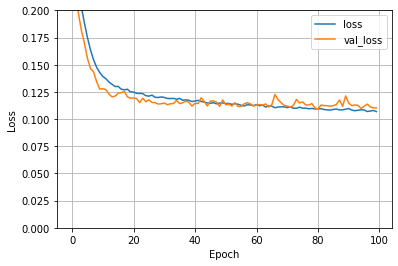

In [822]:
plot_loss_power(history_cu4_power_drag)

### How well did it work? Part three...

In [823]:
true_power = cu4_power[cu4_power.index.isin(test_features_cu4_power_drag.index)][['drag_force', 'u']]
true_power['product'] = true_power['drag_force'] * true_power['u']
true_power

,drag_force,u,product
4,0.000000,0.000000,0.000000
17,0.000000,0.000000,0.000000
25,0.000000,0.000000,0.000000
29,0.000000,0.000000,0.000000
30,0.000000,0.000000,0.000000
...,...,...,...
10204,12.206702,-1.199148,-14.637638
10208,7.784577,-1.022913,-7.962946
10211,14.954201,-1.042609,-15.591379
10212,16.422499,-0.976752,-16.040700


In [824]:
test_features_cu4_power_product = test_features_cu4_power_product[['x','eta','u','v']]

In [825]:
predicted_power_product = dnn_model_cu4_power_product.predict(test_features_cu4_power_product)

64/64 [==============================] - 0s 1ms/step


Now, we will compare real power against predicted power. It makes sense that the power is negative since the waves are exerting negative force on the overhead wind.

In [826]:
products = dx * np.squeeze(true_power)['drag_force'] * np.squeeze(true_power)['u']
products
real_power = np.sum(products)
real_power

-28.33418935082215

In [827]:
products2 = tf.math.scalar_mul(dx, predicted_power_product)
pred_power = np.sum(products2)
pred_power

-23.712568

The model does a bit worse at predicting power now. Percent error is 16.3%.

In [828]:
np.abs((pred_power - real_power) / real_power) * 100

16.311110970983165